In [1]:
# Import library yang diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from joblib import dump

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Konfigurasi paths
WORKDIR = r"d:\Project Akhir PSD"
DATA_PATH = os.path.join(WORKDIR, 'dataset', 'CatsDogs_TRAIN.arff')
ARTIFACT_PIPELINE = os.path.join(WORKDIR, 'preprocessing_pipeline.joblib')
ARTIFACT_DATA = os.path.join(WORKDIR, 'data_processed.npz')
LABEL_ENCODER_PATH = os.path.join(WORKDIR, 'label_encoder.joblib')
FIG_DIR = os.path.join(WORKDIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print('Working dir:', WORKDIR)
print('Data path:', DATA_PATH)
print('Figures dir:', FIG_DIR)

Working dir: d:\Project Akhir PSD
Data path: d:\Project Akhir PSD\dataset\CatsDogs_TRAIN.arff
Figures dir: d:\Project Akhir PSD\figures


## 1. Muat dataset

Muat file ARFF dan konversi ke `pandas.DataFrame`. Tampilkan beberapa baris awal dan tipe data.

In [2]:
# Muat ARFF
data, meta = arff.loadarff(DATA_PATH)
df = pd.DataFrame(data)

print('Shape:', df.shape)
print('\nContoh baris:')
print(df.head())
print('\nTipe data (sample kolom):')
print(df.dtypes[:10])

Shape: (164, 14774)

Contoh baris:
       att1      att2      att3      att4      att5      att6      att7  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.207062  0.031433 -0.262360 -0.391235 -0.246460 -0.277374 -0.277557   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.023865  0.024109  0.022766  0.021942  0.024628  0.028595  0.028839   

       att8      att9     att10  ...  att14765  att14766  att14767  att14768  \
0  0.000000  0.000000  0.000000  ...  0.032227  0.039581  0.038422  0.040680   
1 -0.056396  0.195435  0.367248  ...  0.006866  0.003357  0.002075  0.004608   
2  0.000000  0.000000  0.000000  ... -0.012970 -0.004761 -0.000519  0.005432   
3  0.000000  0.000000  0.000000  ...  0.040802  0.082947  0.080322  0.050110   
4  0.032928  0.035553  0.039764  ... -0.002899 -0.003632 -0.002960 -0.003571   

   att14769  att14770  att14771  

## 2. Pemeriksaan kualitas data

Periksa missing values dan duplikat. Jika ada duplikat persis, akan di-drop untuk reproducibility.

In [3]:
# Pemeriksaan missing dan duplikat
missing_count = df.isnull().sum().sum()
duplicate_count = df.duplicated().sum()
print('Total missing values:', missing_count)
print('Total duplicate rows:', duplicate_count)

if duplicate_count > 0:
    print('\nContoh duplikat:')
    print(df[df.duplicated()].head())
    df = df.drop_duplicates().reset_index(drop=True)
    print('\nSetelah drop duplicates, shape:', df.shape)

Total missing values: 0
Total duplicate rows: 1

Contoh duplikat:
         att1      att2      att3      att4      att5      att6      att7  \
145 -0.000854 -0.000397  0.000061  0.000031 -0.000122 -0.000244 -0.000275   

         att8      att9     att10  ...  att14765  att14766  att14767  \
145 -0.000031  0.000183 -0.000153  ...   0.07608 -0.007355 -0.067078   

     att14768  att14769  att14770  att14771  att14772  att14773  target  
145 -0.127411 -0.185608 -0.206787 -0.201782 -0.182892 -0.139831  b'Dog'  

[1 rows x 14774 columns]

Setelah drop duplicates, shape: (163, 14774)


## 3. Identifikasi fitur dan label

Pisahkan fitur numerik dan kolom kategorikal. Konversi label dari bytes ke string jika diperlukan, dan standarisasi label (lower-case).

In [4]:
# Identifikasi kolom
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_col = categorical_cols[0] if categorical_cols else None

print('Jumlah fitur numerik:', len(numerical_cols))
print('Kolom kategorikal:', categorical_cols)
print('Label column:', label_col)

# Jika label berupa bytes (mis. b'Cat'), decode
if label_col is not None:
    if isinstance(df[label_col].iloc[0], (bytes, bytearray)):
        df[label_col] = df[label_col].apply(lambda x: x.decode('utf-8') if isinstance(x, (bytes, bytearray)) else x)
        print('Label di-decode dari bytes ke string')

# Standardisasi label
if label_col is not None:
    df[label_col] = df[label_col].astype(str).str.strip().str.lower()
    print('Distribusi label:')
    print(df[label_col].value_counts())

Jumlah fitur numerik: 14773
Kolom kategorikal: ['target']
Label column: target
Label di-decode dari bytes ke string
Distribusi label:
target
cat    82
dog    81
Name: count, dtype: int64


## 4. Visualisasi untuk verifikasi

Tambahkan beberapa visualisasi untuk membantu memeriksa kualitas dan sifat fitur:
- Distribusi kelas
- Histogram varians fitur numerik
- Boxplot untuk beberapa fitur contoh

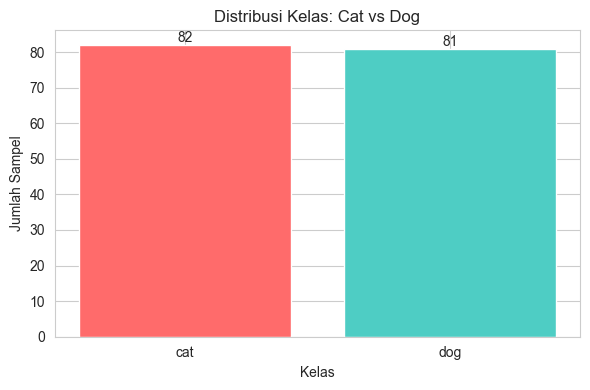

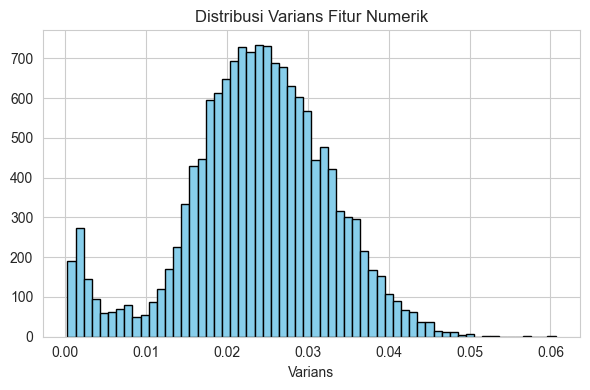

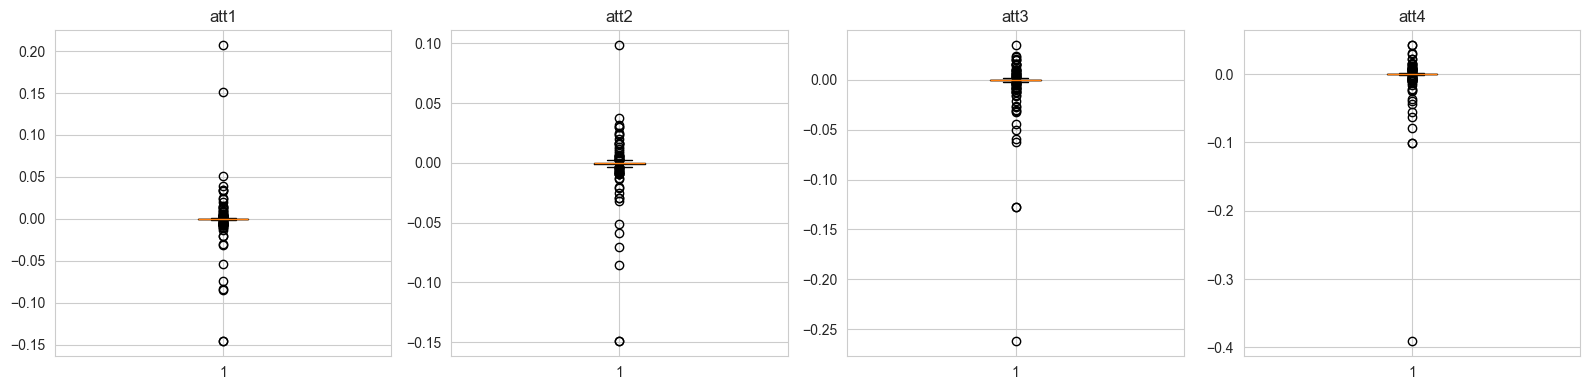

Visualisasi disimpan di: d:\Project Akhir PSD\figures


In [5]:
# 4.1 Distribusi kelas
class_counts = df[label_col].value_counts()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar([str(x) for x in class_counts.index], class_counts.values, color=['#FF6B6B','#4ECDC4'])
ax.set_title('Distribusi Kelas: Cat vs Dog')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Sampel')
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='bottom')
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'class_distribution.png'))
plt.show()

# 4.2 Histogram varians fitur
variances = df[numerical_cols].var(axis=0)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(variances, bins=60, color='skyblue', edgecolor='black')
ax.set_title('Distribusi Varians Fitur Numerik')
ax.set_xlabel('Varians')
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'variance_histogram.png'))
plt.show()

# 4.3 Boxplot contoh 4 fitur
display_feats = numerical_cols[:4]
fig, axes = plt.subplots(1, len(display_feats), figsize=(4*len(display_feats),4))
for i, feat in enumerate(display_feats):
    axes[i].boxplot(df[feat].dropna())
    axes[i].set_title(feat)
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, 'boxplots_first4.png'))
plt.show()

print('Visualisasi disimpan di:', FIG_DIR)

## 5. Seleksi fitur sederhana

Untuk mengurangi fitur yang hampir konstan kita gunakan `VarianceThreshold`. Ini ringan dan cepat.

In [6]:
# VarianceThreshold untuk menghapus fitur hampir konstan
vt = VarianceThreshold(threshold=1e-6)
try:
    vt.fit(df[numerical_cols])
    support_mask = vt.get_support()
    kept_features = [f for f, keep in zip(numerical_cols, support_mask) if keep]
    print('Fitur awal:', len(numerical_cols), '-> Dipertahankan:', len(kept_features))
except Exception as e:
    print('VarianceThreshold gagal:', e)
    kept_features = numerical_cols

numerical_cols_selected = kept_features

Fitur awal: 14773 -> Dipertahankan: 14773


## 6. Split data (stratified 80/20) dan encoding target

Bagi data menjadi training dan test set (80/20) dengan stratified split untuk menjaga proporsi kelas.

In [7]:
# Siapkan X dan y
X = df[numerical_cols_selected].values
y = df[label_col].values

# Encode label ke integer
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Kelas:', list(le.classes_))

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, stratify=y_encoded, random_state=42)
print('Bentuk train:', X_train.shape, 'Bentuk test:', X_test.shape)

# Simpan split untuk reproduksi
np.savez_compressed(ARTIFACT_DATA, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, label_classes=le.classes_)
print('Tersimpan:', ARTIFACT_DATA)

Kelas: ['cat', 'dog']
Bentuk train: (130, 14773) Bentuk test: (33, 14773)
Tersimpan: d:\Project Akhir PSD\data_processed.npz


## 7. Membangun pipeline preprocessing dan menyimpan artifact

Pipeline standar: scaler (StandardScaler). VarianceThreshold sudah dipakai sebelumnya; jika ingin, PCA dapat ditambahkan.

In [8]:
# Susun pipeline
components = []
if len(numerical_cols_selected) < len(numerical_cols):
    components.append(('variance', VarianceThreshold(threshold=1e-6)))
components.append(('scaler', StandardScaler()))
# components.append(('pca', PCA(n_components=100, random_state=42)))  # opsional

pipe = Pipeline(components)
# Fit pipeline pada data train
pipe.fit(X_train)

# Simpan pipeline dan label encoder
dump(pipe, ARTIFACT_PIPELINE)
dump(le, LABEL_ENCODER_PATH)
print('Pipeline tersimpan di:', ARTIFACT_PIPELINE)
print('Label encoder tersimpan di:', LABEL_ENCODER_PATH)

Pipeline tersimpan di: d:\Project Akhir PSD\preprocessing_pipeline.joblib
Label encoder tersimpan di: d:\Project Akhir PSD\label_encoder.joblib


## 8. Verifikasi singkat dan kesimpulan

Transform beberapa sampel dan tampilkan ringkasan. Catatan langkah berikutnya untuk modeling.

In [9]:
# Verifikasi transformasi
X_sample_trans = pipe.transform(X_train[:5])
print('Bentuk hasil transform (contoh):', X_sample_trans.shape)

print('\nRingkasan:')
print(' - Preprocessing pipeline:', ARTIFACT_PIPELINE)
print(' - Processed arrays:', ARTIFACT_DATA)
print(' - Label encoder:', LABEL_ENCODER_PATH)
print('\nLangkah selanjutnya: latih model menggunakan file processed arrays dan pipeline yang sama.')

Bentuk hasil transform (contoh): (5, 14773)

Ringkasan:
 - Preprocessing pipeline: d:\Project Akhir PSD\preprocessing_pipeline.joblib
 - Processed arrays: d:\Project Akhir PSD\data_processed.npz
 - Label encoder: d:\Project Akhir PSD\label_encoder.joblib

Langkah selanjutnya: latih model menggunakan file processed arrays dan pipeline yang sama.


## Catatan
- Jika dataset sangat besar atau PCA diperlukan, jalankan PCA offline atau gunakan lingkungan dengan memori cukup.
- Simpan juga contoh file audio (jika menggunakan upload saat demo) di folder `d:\Project Akhir PSD\demo_samples`.

Selesai — notebook preprocessing siap dipakai untuk tahap modeling.